# MODIS Water XGBOOST 

Version: 0.2.0

Date modified: 02.21.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

sys.path.append('../scripts/')
import notebook_util as nu

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
FIGURE_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/adapt/nobackup/people/cssprad1/projects/modis_water/data/training_data/v2.0.0/'

qaMask = '/adapt/nobackup/people/cssprad1/projects/modis_water/data/qa_masks'
waterMask = '/adapt/nobackup/people/cssprad1/projects/modis_water/data/water_masks/Min2000_2019'

test_data_basepath = '/adapt/nobackup/people/cssprad1/projects/modis_water/data/test_data/'

GPU = False
TILE = 'GLOBAL'
MODEL = 'xgboost'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day']
# Columns that the user wants to drop for training purposes. 
colsToDrop = []#'sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [3]:
if GPU:
    nu.setup_one_gpu() # Choose the GPU with the lowest memory usage

In [4]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [5]:
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = [fv for fv in glob.glob(glob_string)]
data_path = data_paths[0]
pprint(data_paths)

['/adapt/nobackup/people/cssprad1/projects/modis_water/data/training_data/v2.0.0/MOD09_GLOBAL_5516128_2_0_0.parquet.gzip']


In [6]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             trainTestSplit=True,
                                             multi=False)

In [7]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [8]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,4375821.0,430.570666,553.029258,-100.0,33.0,293.0,614.0,16000.0
sur_refl_b02_1,4375821.0,1511.709590,1489.146343,-100.0,2.0,1473.0,2743.0,16000.0
sur_refl_b03_1,4375821.0,290.356844,345.720484,-100.0,145.0,222.0,345.0,15705.0
sur_refl_b04_1,4375821.0,468.504802,443.948465,-100.0,138.0,436.0,644.0,16000.0
sur_refl_b05_1,4375821.0,1664.046205,1542.862460,-100.0,20.0,1822.0,3076.0,16000.0
sur_refl_b06_1,4375821.0,1232.200017,1145.351071,-100.0,81.0,1198.0,2140.0,16000.0
sur_refl_b07_1,4375821.0,658.392633,756.377695,-100.0,43.0,465.0,1003.0,12519.0
ndvi,4375821.0,626.817631,8569.724912,-32762.0,-5652.0,3241.0,6963.0,32762.0
ndwi1,4375821.0,-2842.369483,7130.836139,-32759.0,-9090.0,-617.0,2030.0,32767.0
ndwi2,4375821.0,-52.897736,9000.925498,-32759.0,-6923.0,2512.0,5942.0,32767.0


In [9]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [10]:
ndviOverTenK = output_interesting_idx(X_train, 'ndvi', 10000)
ndviOverTenK

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
715088,4,-30,39,284,25,120,67,13076,-16666,-26216
1946348,4,-10,227,98,-7,101,39,23333,-12197,-16896
2688546,7,-9,208,134,-3,425,335,14464,-10432,-10552
4266030,-12,27,57,144,177,161,75,26000,-7127,-4705
5264586,-1,102,-100,28,344,240,137,10198,-4035,-1464
...,...,...,...,...,...,...,...,...,...,...
2710694,-6,43,260,76,23,372,315,13243,-7927,-7597
52127,14,-8,10,29,-4,82,72,28870,-12162,-12500
422683,15,-31,195,191,-6,111,59,28750,-17750,-32142
5505133,-62,2057,143,355,1840,1002,542,10621,3448,5829


In [11]:
output_interesting_idx(X_train, 'ndwi1', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
3907174,-77,-79,107,-4,-75,15,3,128,14687,10789
2368761,15,-5,164,134,1,8,20,-20000,22203,-16666
799493,-1,-32,123,70,2,2,15,9393,11333,27647
3170502,69,-6,91,105,63,1,3,-11904,14000,30000
1029476,-100,-100,2802,1842,-52,80,9,0,24464,11978
...,...,...,...,...,...,...,...,...,...,...
1953066,-28,-56,108,123,-32,88,29,3333,20536,31481
1796380,-24,-4,-100,-18,-16,7,8,-7142,28870,-30000
4198572,-71,-75,138,15,-53,72,46,273,31248,-23812
4091680,15,-4,210,209,18,6,13,-17272,15536,-18888


In [12]:
output_interesting_idx(X_train, 'ndwi2', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
297424,38,-12,215,163,-6,31,2,-19230,-22631,14000
3907174,-77,-79,107,-4,-75,15,3,128,14687,10789
1779350,-100,-100,303,236,-2,70,34,0,-8870,20303
4208960,12,-3,100,88,-2,59,5,-16666,-11071,25536
472873,14,-5,167,139,-18,93,1,-21111,-11136,15000
...,...,...,...,...,...,...,...,...,...,...
5109974,203,419,287,291,151,22,-32,3472,9002,11653
1580829,22,-5,126,111,4,15,8,-15882,-20000,22203
80190,50,-16,292,188,-18,61,4,-19411,-17111,16666
986009,-66,-25,22,-67,-4,33,30,-4505,-6964,21072


## XGBOOST

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [14]:
hyperparameters = {'objective': 'binary:logistic',
                   'n_estimators':200,
                   'base_score': None,
                   'booster': None,
                   'colsample_bylevel': None,
                   'colsample_bynode': None,
                   'colsample_bytree': None,
                   'gamma': None,
                   'gpu_id': 0,
                   'interaction_constraints': None,
                   'learning_rate': 0.003,
                   'max_delta_step': None,
                   'max_depth': 15,
                   'min_child_weight': None,
                   'monotone_constraints': None,
                   'n_jobs': -1,
                   'num_parallel_tree': None,
                   'random_state': None,
                   'reg_alpha': None,
                   'reg_lambda': None,
                   'scale_pos_weight': None,
                   'subsample': None,
                   'tree_method': 'gpu_hist',
                   'validate_parameters': None,
                   'verbosity': None}

In [15]:
classifier = xgb.XGBClassifier(**hyperparameters)

In [16]:
eval_set = [(X_train, y_train), (X_val, y_val)]
eval_metric = ["error","auc"]

In [17]:
classifier.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=10)

[0]	validation_0-error:0.01360	validation_0-auc:0.99791	validation_1-error:0.01725	validation_1-auc:0.99766
[1]	validation_0-error:0.01338	validation_0-auc:0.99794	validation_1-error:0.01696	validation_1-auc:0.99768
[2]	validation_0-error:0.01339	validation_0-auc:0.99795	validation_1-error:0.01692	validation_1-auc:0.99769
[3]	validation_0-error:0.01339	validation_0-auc:0.99794	validation_1-error:0.01694	validation_1-auc:0.99769
[4]	validation_0-error:0.01337	validation_0-auc:0.99795	validation_1-error:0.01689	validation_1-auc:0.99769
[5]	validation_0-error:0.01337	validation_0-auc:0.99795	validation_1-error:0.01690	validation_1-auc:0.99769
[6]	validation_0-error:0.01336	validation_0-auc:0.99795	validation_1-error:0.01694	validation_1-auc:0.99769
[7]	validation_0-error:0.01334	validation_0-auc:0.99796	validation_1-error:0.01690	validation_1-auc:0.99770
[8]	validation_0-error:0.01335	validation_0-auc:0.99805	validation_1-error:0.01688	validation_1-auc:0.99779
[9]	validation_0-error:0.013

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.003, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

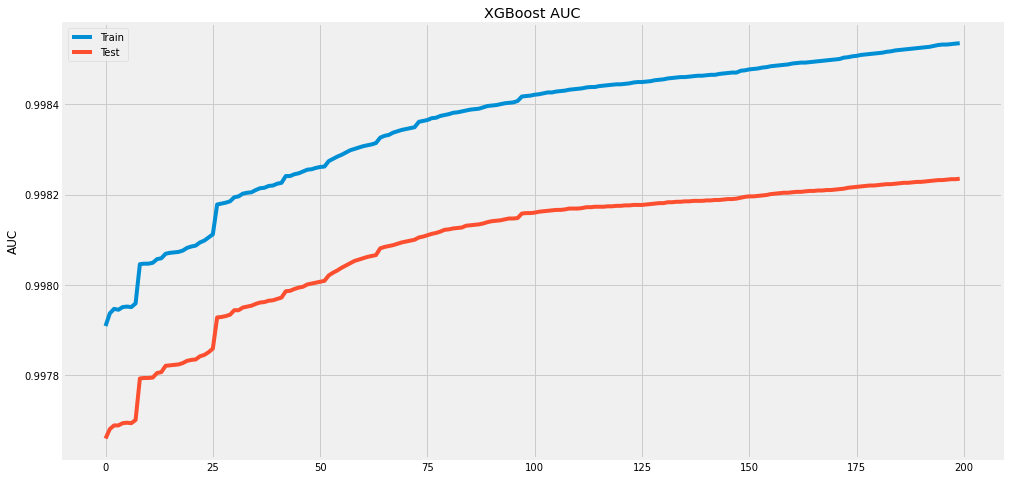

In [18]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

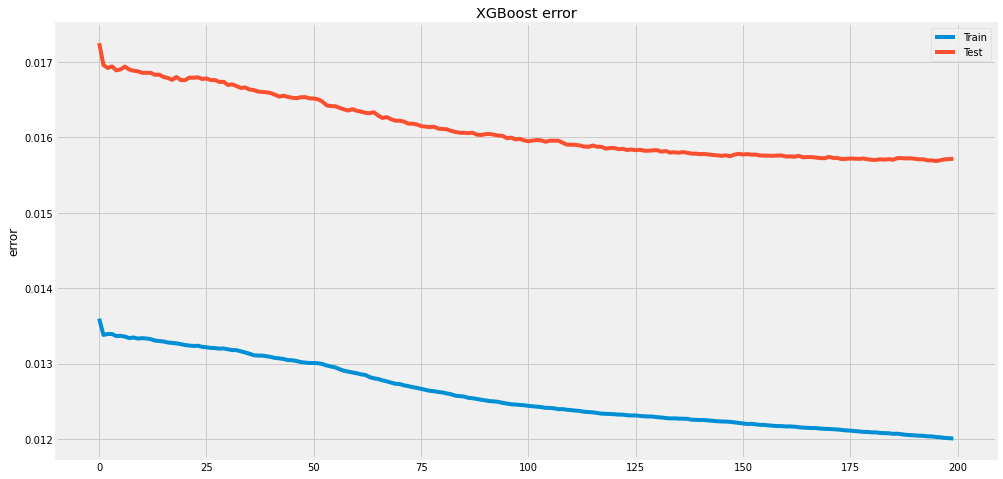

In [19]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('XGBoost error')
plt.show()

## Model testing and training/testing data validation

### Get model metrics

In [20]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.984

In [21]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [22]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

In [23]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    599015
           1       0.98      0.98      0.98    494941

    accuracy                           0.98   1093956
   macro avg       0.98      0.98      0.98   1093956
weighted avg       0.98      0.98      0.98   1093956

Test Recall
-------------------------------------------------------
0.9853910169194428
Confusion Matrix
-------------------------------------------------------
[[590264   8751]
 [  8301 486640]]


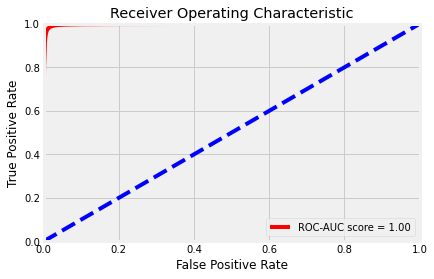

In [24]:
probs = classifier.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC-AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## NDVI Over 10,000

In [25]:
ndviOver10Predictions = classifier.predict(ndviOverTenK)
withPrediction = ndviOverTenK.assign(water_prediction=ndviOver10Predictions)
print('Number of rows: {}'.format(len(ndviOverTenK.index)))
print('Number of water predictions: {}'.format(np.count_nonzero(ndviOver10Predictions == 1)))
print('Number of land predictions: {}'.format(np.count_nonzero(ndviOver10Predictions == 0)))
withPrediction

Number of rows: 91849
Number of water predictions: 87131
Number of land predictions: 4718


,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2,water_prediction
715088,4,-30,39,284,25,120,67,13076,-16666,-26216,1
1946348,4,-10,227,98,-7,101,39,23333,-12197,-16896,1
2688546,7,-9,208,134,-3,425,335,14464,-10432,-10552,1
4266030,-12,27,57,144,177,161,75,26000,-7127,-4705,1
5264586,-1,102,-100,28,344,240,137,10198,-4035,-1464,1
...,...,...,...,...,...,...,...,...,...,...,...
2710694,-6,43,260,76,23,372,315,13243,-7927,-7597,1
52127,14,-8,10,29,-4,82,72,28870,-12162,-12500,1
422683,15,-31,195,191,-6,111,59,28750,-17750,-32142,1
5505133,-62,2057,143,355,1840,1002,542,10621,3448,5829,0


In [26]:
withPrediction[withPrediction['water_prediction'] == 0]

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2,water_prediction
1271940,-2,879,-67,115,1415,718,140,10045,1008,7252,0
1942717,-69,2752,100,380,2406,1227,399,10514,3832,7467,0
3380868,-21,1874,-79,203,2987,1487,398,10226,1151,6496,0
1023678,25,-16,273,520,1396,1037,541,19981,-10313,-10609,0
3997524,-34,3837,-100,209,3865,1508,272,10178,4357,8676,0
...,...,...,...,...,...,...,...,...,...,...,...
1731756,-100,2653,83,236,2451,1072,302,10783,4244,7956,0
1289732,-2,201,198,415,2389,2012,1156,10201,-8183,-7037,0
992887,-19,1406,-87,108,1710,837,210,10273,2536,7400,0
53040,-70,1525,-100,-100,2893,2489,1473,10962,-2401,173,0


## Permutation importance

In [27]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

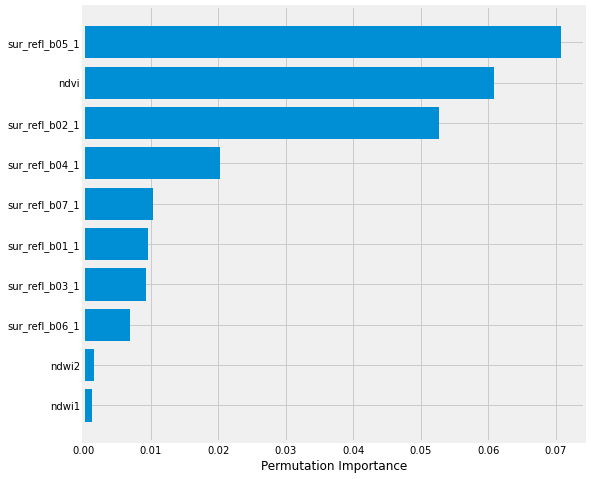

In [28]:
png_save_path = 'mw_all_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

In [29]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [30]:
model_save_path = 'mw_all_{}_{}_{}_{}_2.0.0_tuned_{}.sav'.format(TILE,
                                                              score,
                                                              hyperparameters['n_estimators'],
                                                              MODEL,
                                                              'gpu' if GPU else 'cpu',
                                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_all_GLOBAL_0.984_200_xgboost_2.0.0_tuned_cpu.sav
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.003, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)


['/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_all_GLOBAL_0.984_200_xgboost_2.0.0_tuned_cpu.sav']

# Testing: Raster testing

In [42]:
TILE = 'h09v05'

In [43]:
DAY = 155
YEAR = 2001
PATH = os.path.join(test_data_basepath, '{}/'.format(TILE))

In [44]:
vars_list_gq = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

['/adapt/nobackup/people/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GQ.A2001155.h09v05.061.2020061221201-sur_refl_b01_1.tif',
 '/adapt/nobackup/people/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GQ.A2001155.h09v05.061.2020061221201-sur_refl_b02_1.tif',
 '/adapt/nobackup/people/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001155.h09v05.061.2020061221201-sur_refl_b03_1.tif',
 '/adapt/nobackup/people/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001155.h09v05.061.2020061221201-sur_refl_b04_1.tif',
 '/adapt/nobackup/people/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001155.h09v05.061.2020061221201-sur_refl_b05_1.tif',
 '/adapt/nobackup/people/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001155.h09v05.061.2020061221201-sur_refl_b06_1.tif',
 '/adapt/nobackup/people/cssprad1/projects/modis_water/data/test_data/h09v05/MOD09GA.A2001155.h09v05.061.2020061221201-sur_refl_b07_1.tif']

## Get dimensions of inputs

In [45]:
vrt_opts = gdal.BuildVRTOptions(separate=True)
dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_opts)
nrows, ncols = dd.RasterYSize, dd.RasterXSize
dd = None
if os.path.exists('tmp.vrt'):
    os.remove('tmp.vrt') 
nrows, ncols

(4800, 4800)

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [46]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    print(dd.GetGeoTransform())
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [48]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

(-10007554.677, 231.65635799999998, 0.0, 4447802.078667, 0.0, -231.65635799999998)
Raster as ndarray
[[ 1631  2420   970 ...  1947 -1605  -429]
 [ 1631  2420   970 ...  1947 -1605  -429]
 [ 1757  2671   970 ...  2064 -1121    64]
 ...
 [ 1609  3526  1722 ...  3733    34  2984]
 [ 1609  3526  2020 ...  3733   -98  2604]
 [ 2512  4393  2020 ...  2724   997  3596]]
460.8 MB size


In [49]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [50]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

Making predictions from raster
CPU times: user 10min 3s, sys: 2.01 s, total: 10min 5s
Wall time: 18.2 s


In [51]:
shp = (4800, 4800)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

## Inputreshapet raster: description and histogram

In [52]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,23040000.0,1781.829258,1471.216914,-28672.0,886.0,1381.0,2105.0,13398.0
sur_refl_b02_1,23040000.0,2880.551188,2429.777644,-28672.0,2363.0,2708.0,3258.0,10571.0
sur_refl_b03_1,23040000.0,1159.777648,1435.113358,-28672.0,470.0,709.0,1101.0,11715.0
sur_refl_b04_1,23040000.0,1554.709241,1409.466010,-28672.0,822.0,1108.0,1637.0,11545.0
sur_refl_b05_1,23040000.0,3418.176141,975.569251,-28672.0,2848.0,3188.0,3735.0,9617.0
sur_refl_b06_1,23040000.0,3178.879154,993.398921,-28672.0,2480.0,3028.0,3734.0,8993.0
sur_refl_b07_1,23040000.0,2346.147320,1044.309798,-28672.0,1488.0,2213.0,3073.0,6895.0
ndvi,23040000.0,3193.082294,2206.677682,-32307.0,1817.0,2861.0,4644.0,32203.0
ndwi1,23040000.0,-289.649651,1688.980101,-32272.0,-1316.0,-670.0,530.0,32558.0
ndwi2,23040000.0,1423.866166,2278.654414,-32539.0,-374.0,933.0,3008.0,32702.0


#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [53]:
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [54]:
qa_list = [fn for fn in glob.glob(os.path.join(qaMask, '*A{}{:03}.{}*bad_good_mask.tif'.format(YEAR, DAY, TILE)))]
water_list = [fn for fn in glob.glob(os.path.join(waterMask, '*{}*.tif'.format(TILE)))]
qa_mask = qa_list[0]
water_mask = water_list[0]
print(water_mask)
print(qa_mask)
ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
waterMask = gdal.Open(water_mask, gdal.GA_ReadOnly)
qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMaskMatrix = waterMask.GetRasterBand(1).ReadAsArray().astype(np.int16)
ds = None
waterMask = None

/adapt/nobackup/people/cssprad1/projects/modis_water/data/water_masks/Min2000_2019/MOD44W_h09v05_min2000_2019.tif
/adapt/nobackup/people/cssprad1/projects/modis_water/data/qa_masks/MOD09GA.A2001155.h09v05.061.2020061221201_bad_good_mask.tif


In [55]:
waterMaskMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [56]:
maskedResult = np.where(qaMaskMatrix == 0, reshp, -9999)
maskedResultProba = np.where(qaMaskMatrix == 0, probaWater, -9999)
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

# Generating stats for predicted and truth

## Predicted Raster

In [57]:
TILE = 'global_{}_{}'.format(MODEL, TILE)

Text(0.5, 1.0, 'Predicted water mask')

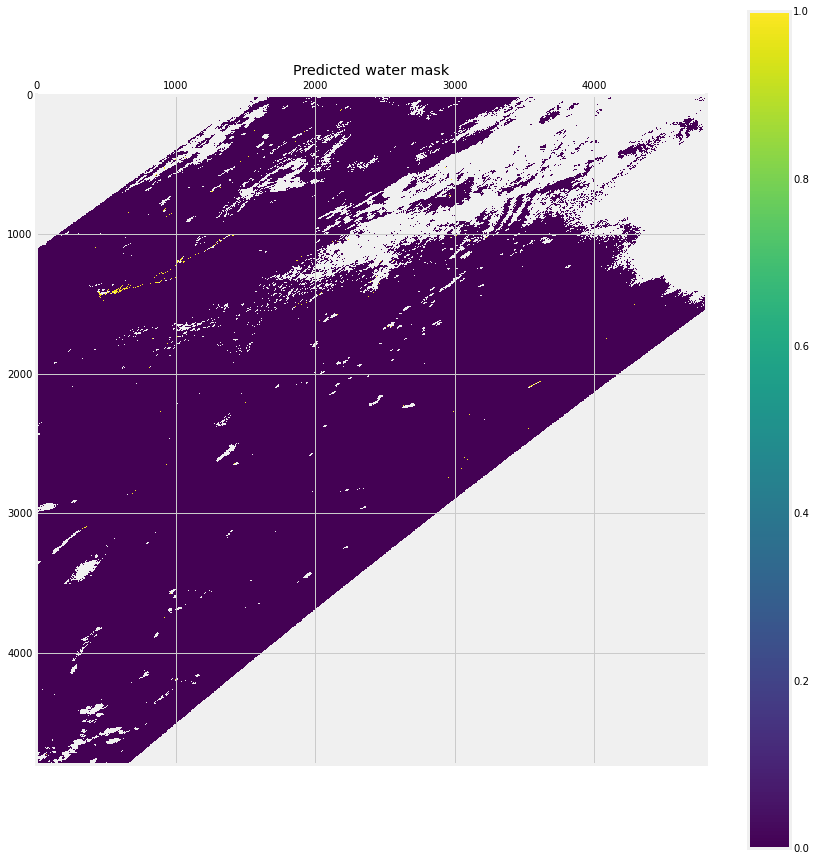

In [68]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResult), fignum=1)
plt.colorbar()
plt.title('Predicted water mask')

## Predicted Probabilities

Text(0.5, 1.0, 'Predicted probabilities of water')

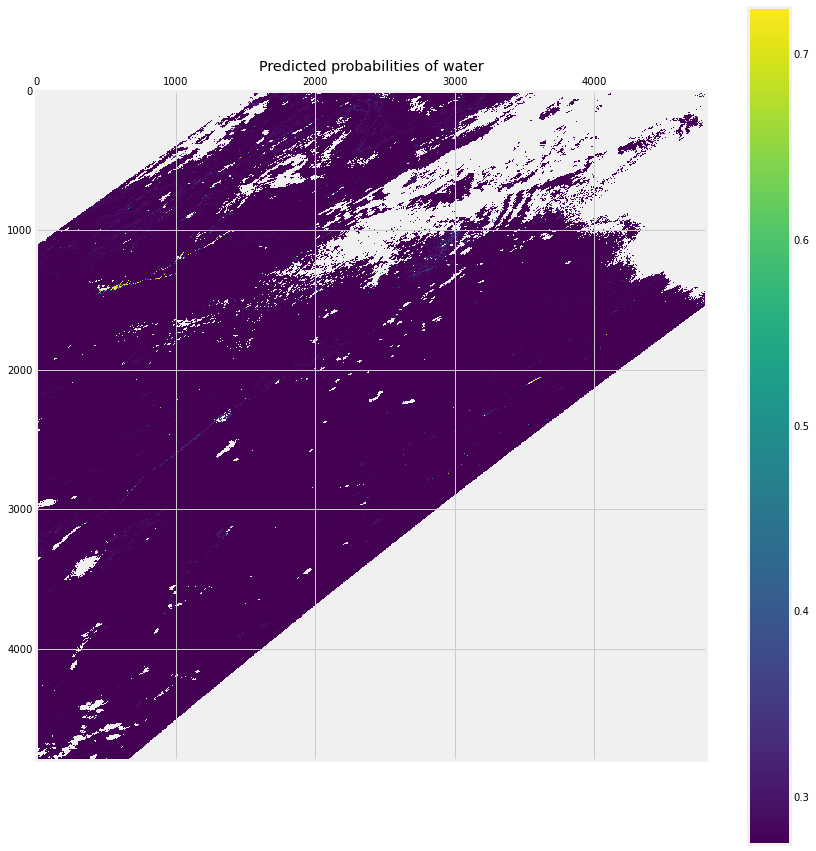

In [59]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResultProba), fignum=1)
plt.colorbar()
plt.title('Predicted probabilities of water')

## Minimum Extent Water Mask

Text(0.5, 1.0, 'Minimum extent water mask')

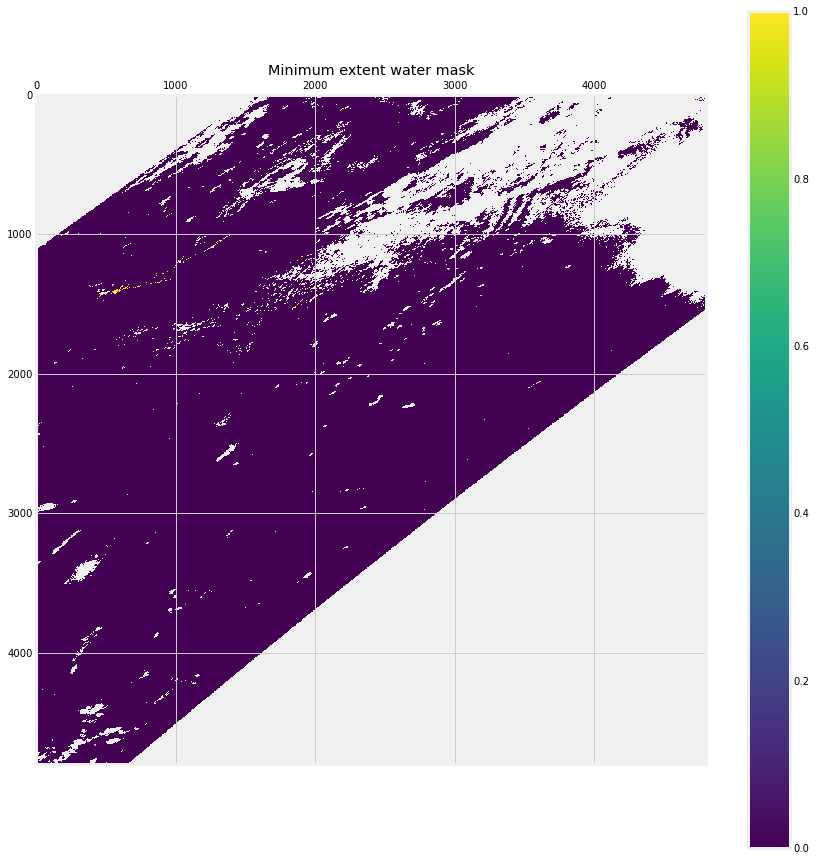

In [60]:
plt.figure(figsize=(15, 15))
truth = np.where(waterMasked==-9999, np.NaN, waterMasked)
truth = np.where(waterMasked==250, np.NaN, truth)
truthPlt = plt.matshow(truth, fignum=1)
plt.colorbar()
plt.title('Minimum extent water mask')

## Metrics on test raster

In [61]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))

### Count num of occurences for each class with the masked predicted result

In [62]:
countNoData = np.count_nonzero(maskedResult == -9999)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 10229344
 Land occurance: 12799663
 Water occurances: 10993


### Count num of occurences for each class with the water mask

In [63]:
countNoDataT = np.count_nonzero(waterMasked == -9999)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 10229344
 Land occurance: 12803049
 Water occurances: 7607


### Model metrics on raster data

In [64]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))

Metrics of Accuracy for Raster Test Data
True Positives:  5536
True Negatives:  12797592
False Positives: 5457
False Negatives: 2071
Total "good" data: 12810656
Accuracy*: 0.9994123642067978
Precision: 0.5035931956699718
Recall: 0.7277507558827396
f1: 0.595268817204301


## Output predicted raster to GeoTiff

In [147]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output probabilies raster masked by good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPathProba, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResultProba)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_218_global_xgboost_h12v09_predicted_xgboost.tif
/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/waterMask_2006_qa_218.tif
/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_218_global_xgboost_h12v09_predicted_probabilities_xgboost.tif
Transform
(-6671703.118, 231.656358, 0.0, 0.0, 0.0, -231.656358)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800
